# Assignment : Secure AI Systems - Red and Blue Teaming an MNIST Classifier

## Introduction
We will create a CNN model to classify handwritten digits from the MNIST

Red Teaming - Then, we explore two critical security vulnerabilities in deep neural networks: **data poisoning attacks** and **adversarial attacks**. 

Blue Teaming - Then we'll implement a **defense mechanism** by retraining the model on a combination of clean and adversarial data. This technique, called adversarial training, helps the model become more robust against these attacks.

In [ ]:
# Install required libraries
# %pip install tensorflow numpy matplotlib scikit-learn adversarial-robustness-toolbox bandit

import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod

## Training CNN Model

Epoch 1/5


/home/susi/Documents/SIS/Assignment/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-26 12:04:33.681889: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9545 - loss: 0.1517 - val_accuracy: 0.9877 - val_loss: 0.0469
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9842 - loss: 0.0497 - val_accuracy: 0.9875 - val_loss: 0.0444
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9895 - loss: 0.0334 - val_accuracy: 0.9875 - val_loss: 0.0435
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9917 - loss: 0.0255 - val_accuracy: 0.9915 - val_loss: 0.0308
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 0.9878 - val_loss: 0.0386
=== METRICS ===
Test Accuracy: 99.00%
Training Time: 73.08s
Inference Time (per image): 0.0768ms
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


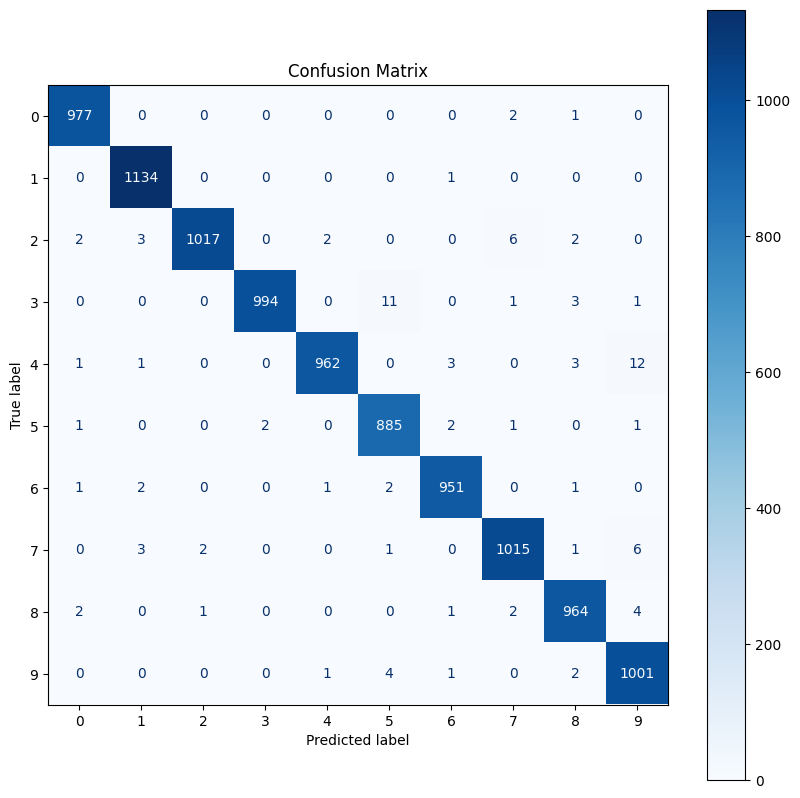

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = build_cnn()

start_time = time.time()
baseline_model.fit(x_train, y_train, epochs=5, validation_split=0.1, verbose=1)
train_time = time.time() - start_time

start_inf = time.time()
loss, acc = baseline_model.evaluate(x_test, y_test, verbose=0)
inf_time = (time.time() - start_inf) / len(x_test)

print(f"=== METRICS ===")
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Training Time: {train_time:.2f}s")
print(f"Inference Time (per image): {inf_time*1000:.4f}ms")

y_pred = np.argmax(baseline_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

## Data Poisoning (Method 1)

Creating Poisoned Dataset...
Training Compromised Model (Attack Phase)...
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== POISONING RESULTS ===
Attack Success Rate (7s classified as 1s): 93.39%


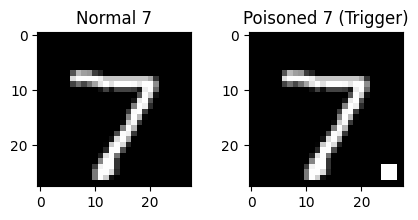

In [ ]:
def add_square(images, labels, source_digit=7, target_digit=1, portion=100):
    x_poisoned = images.copy()
    y_poisoned = labels.copy()

    indices = np.where(labels == source_digit)[0][:portion]
    
    for i in indices:
        x_poisoned[i, 24:27, 24:27, 0] = 1.0 
        y_poisoned[i] = target_digit
        
    return x_poisoned, y_poisoned, indices

x_train_poison, y_train_poison, poisoned_indices = add_square(x_train, y_train, portion=200)

poisoned_model = tf.keras.models.clone_model(baseline_model)
poisoned_model.fit(x_train_poison, y_train_poison, epochs=2, verbose=0)

x_test_trigger, y_test_trigger, _ = add_square(x_test, y_test, portion=1000)
trigger_indices = np.where(y_test == 7)[0]
x_test_trigger_sevens = x_test_trigger[trigger_indices]

preds = np.argmax(poisoned_model.predict(x_test_trigger_sevens), axis=1)
success_rate = np.mean(preds == 1) # How many were misclassified as target '1'?

print(f"\n=== POISONING RESULTS ===")
print(f"Attack Success Rate (7s classified as 1s): {success_rate*100:.2f}%")

# Visualization
plt.figure(figsize=(5,2))
plt.subplot(1,2,1); plt.title("Normal 7"); plt.imshow(x_test[trigger_indices[0]], cmap='gray')
plt.subplot(1,2,2); plt.title("Poisoned 7"); plt.imshow(x_test_trigger_sevens[0], cmap='gray')
plt.show()

## Data Poisoning (Method 2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== ADVERSARIAL ATTACK RESULTS ===
Accuracy on Clean Data: 99.00%
Accuracy on Adversarial Data: 30.07%


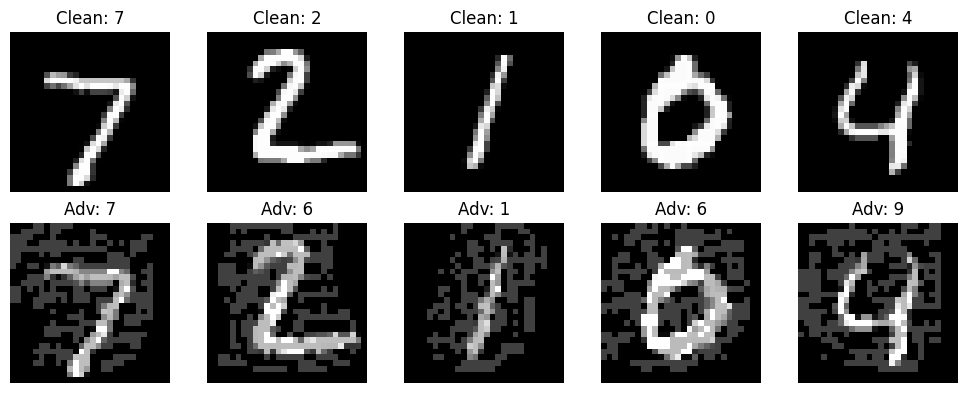

In [5]:
classifier = KerasClassifier(model=baseline_model, clip_values=(0, 1), use_logits=False)

attacker = FastGradientMethod(estimator=classifier, eps=0.25)
x_test_adv = attacker.generate(x=x_test)

preds_clean = np.argmax(baseline_model.predict(x_test), axis=1)
preds_adv = np.argmax(baseline_model.predict(x_test_adv), axis=1)

acc_clean = accuracy_score(y_test, preds_clean)
acc_adv = accuracy_score(y_test, preds_adv)

print(f"\n=== ADVERSARIAL ATTACK RESULTS ===")
print(f"Accuracy on Clean Data: {acc_clean*100:.2f}%")
print(f"Accuracy on Adversarial Data: {acc_adv*100:.2f}%")

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Clean: {preds_clean[i]}")
    plt.axis('off')
    
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test_adv[i].reshape(28,28), cmap='gray')
    plt.title(f"Adv: {preds_adv[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# We generate FGSM samples from the TRAINING data this time
x_train_adv = attacker.generate(x=x_train[:10000])
y_train_adv = y_train[:10000]

x_combined = np.concatenate((x_train[:10000], x_train_adv))
y_combined = np.concatenate((y_train[:10000], y_train_adv))

# Retraining Model with Adversarial Data (Defensive Step)
robust_model = build_cnn() # specific new instance
robust_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
robust_model.fit(x_combined, y_combined, epochs=3, batch_size=64, verbose=0)

# Re-Test on the Attack Data 
acc_robust = accuracy_score(y_test, np.argmax(robust_model.predict(x_test_adv), axis=1))

print(f"\n=== DEFENSE RESULTS ===")
print(f"Accuracy on Adversarial Data (Before Defense): {acc_adv*100:.2f}%")
print(f"Accuracy on Adversarial Data (After Defense): {acc_robust*100:.2f}%")

/home/susi/Documents/SIS/Assignment/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== DEFENSE RESULTS ===
Accuracy on Adversarial Data (Before Defense): 30.07%
Accuracy on Adversarial Data (After Defense): 95.75%
SUCCESS: The model is now more robust against FGSM attacks.
